In [4]:
#@title Step 1: Setup & Libraries Installation
# ---
# First step is to install all the required libraries.
# The `-q` flag keeps the output clean.
# ---
print(" Step 1: Installing required libraries...")
!pip install pandas numpy matplotlib seaborn scikit-learn statsmodels tensorflow pyspark sqlalchemy streamlit pyngrok rpy2 gradio -q
print(" Libraries installed.")

# ---
# Now, let's import all the installed libraries.
# ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, classification_report, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import sqlite3
from sqlalchemy import create_engine
import joblib
from faker import Faker
import random
from datetime import datetime, timedelta
import warnings
import plotly.express as px
import plotly.graph_objects as go

warnings.filterwarnings('ignore')

# Activating rpy2 for R integration
%load_ext rpy2.ipython

print(" Step 1: All libraries installed and imported successfully!")


 Step 1: Installing required libraries...
 Libraries installed.
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
 Step 1: All libraries installed and imported successfully!


In [5]:
#@title Step 2: Dummy Dataset Creation
# ---
# Let's create a realistic dummy dataset so that the notebook can run without manual uploads.
# This will simulate the 'indian_ecommerce_sales.csv' file.
# ---
print("\n Step 2: Creating a realistic dummy dataset...")
fake = Faker('en_IN')

# Dataset parameters
num_records = 2500
start_date = datetime(2022, 1, 1)
end_date = datetime(2024, 12, 31)

# Product catalog
categories = ['Electronics', 'Clothing', 'Home & Kitchen', 'Books', 'Beauty & Personal Care', 'Sports']
products = {
    'Electronics': ['Smartphone', 'Laptop', 'Headphones', 'Smartwatch'],
    'Clothing': ['T-Shirt', 'Jeans', 'Saree', 'Kurta'],
    'Home & Kitchen': ['Blender', 'Cookware Set', 'Bedsheet', 'Air Fryer'],
    'Books': ['Fiction Novel', 'Self-Help Book', 'Cookbook', 'History Book'],
    'Beauty & Personal Care': ['Shampoo', 'Moisturizer', 'Sunscreen', 'Lipstick'],
    'Sports': ['Cricket Bat', 'Yoga Mat', 'Dumbbells', 'Running Shoes']
}
unit_prices = {
    'Smartphone': 15000, 'Laptop': 50000, 'Headphones': 2500, 'Smartwatch': 4000, 'T-Shirt': 500,
    'Jeans': 1500, 'Saree': 2000, 'Kurta': 800, 'Blender': 3000, 'Cookware Set': 4500, 'Bedsheet': 1200,
    'Air Fryer': 6000, 'Fiction Novel': 300, 'Self-Help Book': 400, 'Cookbook': 500, 'History Book': 600,
    'Shampoo': 250, 'Moisturizer': 350, 'Sunscreen': 450, 'Lipstick': 600, 'Cricket Bat': 2000,
    'Yoga Mat': 800, 'Dumbbells': 1500, 'Running Shoes': 3000
}
regions = ['North', 'South', 'East', 'West', 'Central']
payment_modes = ['UPI', 'Credit Card', 'Debit Card', 'COD', 'Net Banking']

# Generate dataset
data = []
for i in range(num_records):
    date = fake.date_between(start_date=start_date, end_date=end_date)
    category = random.choice(categories)
    product_name = random.choice(products[category])
    unit_price = unit_prices[product_name] * (1 + random.uniform(-0.1, 0.1))
    quantity = random.randint(1, 5)

    # Diwali peak season (Oct-Nov)
    if date.month in [10, 11]:
        quantity = random.randint(2, 10)

    total_amount = unit_price * quantity
    record = {
        'Date': date,
        'OrderID': f'ORD{10000+i}',
        'ProductID': f'PROD{list(unit_prices.keys()).index(product_name) + 101}',
        'ProductName': product_name,
        'Category': category,
        'CustomerID': f'CUST{random.randint(1001, 1250)}',
        'Region': random.choice(regions),
        'Quantity': quantity,
        'UnitPrice': round(unit_price, 2),
        'TotalAmount': round(total_amount, 2),
        'PaymentMode': random.choice(payment_modes)
    }
    data.append(record)

# Save to CSV
df = pd.DataFrame(data)
df.to_csv('indian_ecommerce_sales.csv', index=False)
print(f" Step 2: Dummy dataset 'indian_ecommerce_sales.csv' with {len(df)} records created successfully.")
print("\n--- Dataset Head ---")
df.head()



 Step 2: Creating a realistic dummy dataset...
 Step 2: Dummy dataset 'indian_ecommerce_sales.csv' with 2500 records created successfully.

--- Dataset Head ---


,Date,OrderID,ProductID,ProductName,Category,CustomerID,Region,Quantity,UnitPrice,TotalAmount,PaymentMode
0,2024-10-07,ORD10000,PROD117,Shampoo,Beauty & Personal Care,CUST1109,North,5,272.29,1361.47,Credit Card
1,2024-03-18,ORD10001,PROD110,Cookware Set,Home & Kitchen,CUST1211,Central,4,4504.50,18018.02,UPI
2,2022-04-11,ORD10002,PROD119,Sunscreen,Beauty & Personal Care,CUST1096,East,5,445.68,2228.40,Debit Card
3,2022-01-07,ORD10003,PROD122,Yoga Mat,Sports,CUST1238,Central,4,824.29,3297.15,Debit Card
4,2022-07-21,ORD10004,PROD115,Cookbook,Books,CUST1188,North,1,465.98,465.98,UPI


In [10]:
##@title Step 3: Data Loading, Cleaning & Feature Engineering
# ---
# In this step, we will load the dataset, clean it, and create new features.
# ---
print("\n Step 3: Loading, Cleaning, and Engineering Features...")

# Load dataset
df = pd.read_csv('indian_ecommerce_sales.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Remove missing and duplicate records
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Outlier handling using IQR method
Q1 = df['TotalAmount'].quantile(0.25)
Q3 = df['TotalAmount'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# Cap extreme outliers at the upper bound
df['TotalAmount'] = np.where(df['TotalAmount'] > upper_bound, upper_bound, df['TotalAmount'])

# Feature Engineering
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter
df['Weekday'] = df['Date'].dt.day_name()
df['Is_Weekend'] = df['Weekday'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

df_cleaned = df.copy()
print(" Step 3: Data cleaned and new features created successfully.")
print("\n--- Cleaned Data Head ---")
df_cleaned.head()


 Step 3: Loading, Cleaning, and Engineering Features...
 Step 3: Data cleaned and new features created successfully.

--- Cleaned Data Head ---


,Date,OrderID,ProductID,ProductName,Category,CustomerID,Region,Quantity,UnitPrice,TotalAmount,PaymentMode,Month,Year,Quarter,Weekday,Is_Weekend
0,2024-10-07,ORD10000,PROD117,Shampoo,Beauty & Personal Care,CUST1109,North,5,272.29,1361.47,Credit Card,10,2024,4,Monday,0
1,2024-03-18,ORD10001,PROD110,Cookware Set,Home & Kitchen,CUST1211,Central,4,4504.50,18018.02,UPI,3,2024,1,Monday,0
2,2022-04-11,ORD10002,PROD119,Sunscreen,Beauty & Personal Care,CUST1096,East,5,445.68,2228.40,Debit Card,4,2022,2,Monday,0
3,2022-01-07,ORD10003,PROD122,Yoga Mat,Sports,CUST1238,Central,4,824.29,3297.15,Debit Card,1,2022,1,Friday,0
4,2022-07-21,ORD10004,PROD115,Cookbook,Books,CUST1188,North,1,465.98,465.98,UPI,7,2022,3,Thursday,0


In [12]:
#@title Step 4: SQL Integration (SQLite)
# ---
# Store the cleaned data into an SQLite database and run advanced business queries.
# ---
print("\n Step 4: Running SQL queries on the data...")

# Create an in-memory SQLite database and load the dataset
engine = create_engine('sqlite:///:memory:')
df.to_sql('sales', engine, index=False, if_exists='replace')

# Helper function to run and display SQL queries
def run_sql_query(query, title):
    print(f"\n--- {title} ---")
    result_df = pd.read_sql_query(query, engine)
    print(result_df)
    return result_df

# Query 1: Top 5 products by revenue
top_products_df = run_sql_query("""
    SELECT ProductID, ProductName, SUM(TotalAmount) AS TotalRevenue
    FROM sales
    GROUP BY ProductID, ProductName
    ORDER BY TotalRevenue DESC
    LIMIT 5;
""", "Query 1: Top 5 Products by Revenue")

# Query 2: Top 5 customers by lifetime value
customer_ltv_df = run_sql_query("""
    SELECT CustomerID, SUM(TotalAmount) AS LifetimeValue, COUNT(OrderID) AS TotalOrders
    FROM sales
    GROUP BY CustomerID
    ORDER BY LifetimeValue DESC
    LIMIT 5;
""", "Query 2: Top 5 Customers by Lifetime Value")

# Query 3: Region-wise revenue
region_rev_df = run_sql_query("""
    SELECT Region, SUM(TotalAmount) AS TotalRevenue
    FROM sales
    GROUP BY Region
    ORDER BY TotalRevenue DESC;
""", "Query 3: Region-wise Revenue")

print("\n Step 4: SQL queries executed successfully.")



 Step 4: Running SQL queries on the data...

--- Query 1: Top 5 Products by Revenue ---
  ProductID   ProductName  TotalRevenue
0   PROD102        Laptop  2.064489e+06
1   PROD101    Smartphone  2.003883e+06
2   PROD112     Air Fryer  1.574420e+06
3   PROD104    Smartwatch  1.423520e+06
4   PROD110  Cookware Set  1.370906e+06

--- Query 2: Top 5 Customers by Lifetime Value ---
  CustomerID  LifetimeValue  TotalOrders
0   CUST1099   169221.15500           16
1   CUST1092   158778.79875           18
2   CUST1089   157368.13875           16
3   CUST1036   152898.60500           16
4   CUST1175   148356.44500           18

--- Query 3: Region-wise Revenue ---
    Region  TotalRevenue
0     West  3.419385e+06
1    North  3.347671e+06
2    South  3.273168e+06
3  Central  3.101843e+06
4     East  3.074199e+06

 Step 4: SQL queries executed successfully.


In [14]:
#@title Step 5: Apache Spark Integration
# ---
# Use PySpark to simulate analytics on large datasets.
# ---
print("\n Step 5: Performing analytics with Apache Spark...")

try:
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import col, sum, avg

    # Initialize Spark session
    spark = SparkSession.builder.appName("SalesSenseSpark").getOrCreate()

    # Convert Pandas DataFrame to Spark DataFrame
    spark_df = spark.createDataFrame(df)

    # Revenue analysis by Region and Category
    print("\n--- Spark Aggregation: Revenue by Region & Category ---")
    agg_df = (
        spark_df.groupBy("Region", "Category")
        .agg(sum("TotalAmount").alias("TotalRevenue"))
        .orderBy(col("TotalRevenue").desc())
    )

    # Display top 5 results
    agg_df.show(5, truncate=False)

    # Stop Spark session
    spark.stop()
    print(" Step 5: Spark operations completed successfully.")

except Exception as e:
    print(f" Step 5: Spark execution failed. This can happen in some Colab environments. Skipping. Error: {e}")




 Step 5: Performing analytics with Apache Spark...

--- Spark Aggregation: Revenue by Region & Category ---
+-------+-----------+------------------+
|Region |Category   |TotalRevenue      |
+-------+-----------+------------------+
|North  |Electronics|1475006.1062499997|
|West   |Electronics|1279561.645       |
|East   |Electronics|1261994.5499999998|
|Central|Electronics|1256013.7224999997|
|South  |Electronics|1109474.3537499998|
+-------+-----------+------------------+
only showing top 5 rows

 Step 5: Spark operations completed successfully.



⏳ Step 6: Generating visualizations for EDA...

--- Plot 1: Monthly Revenue Trend ---


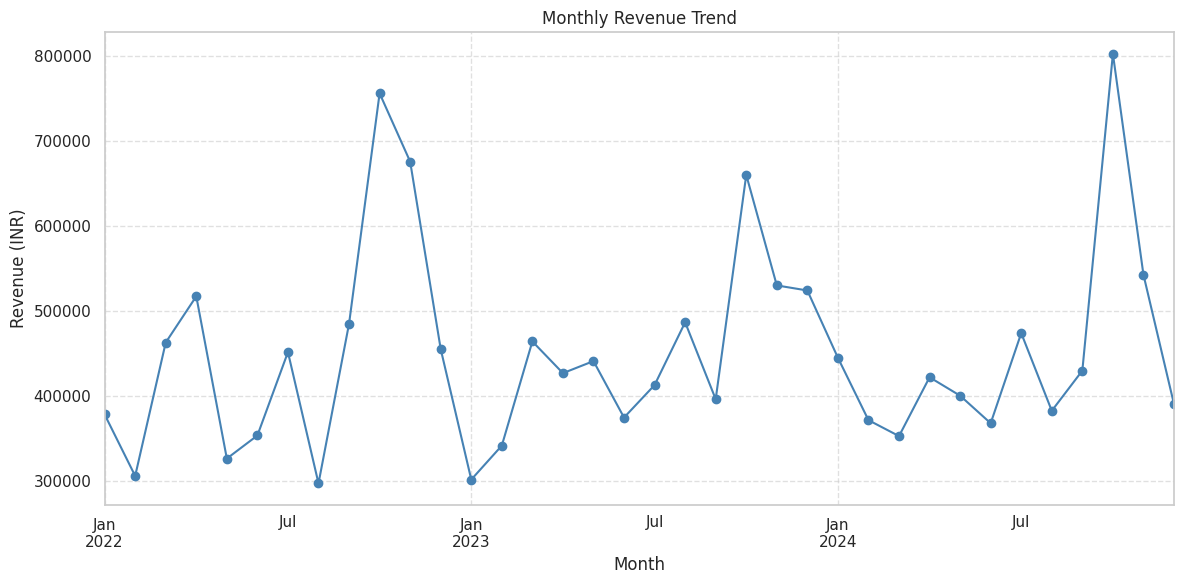


--- Plot 2: Total Sales by Category ---


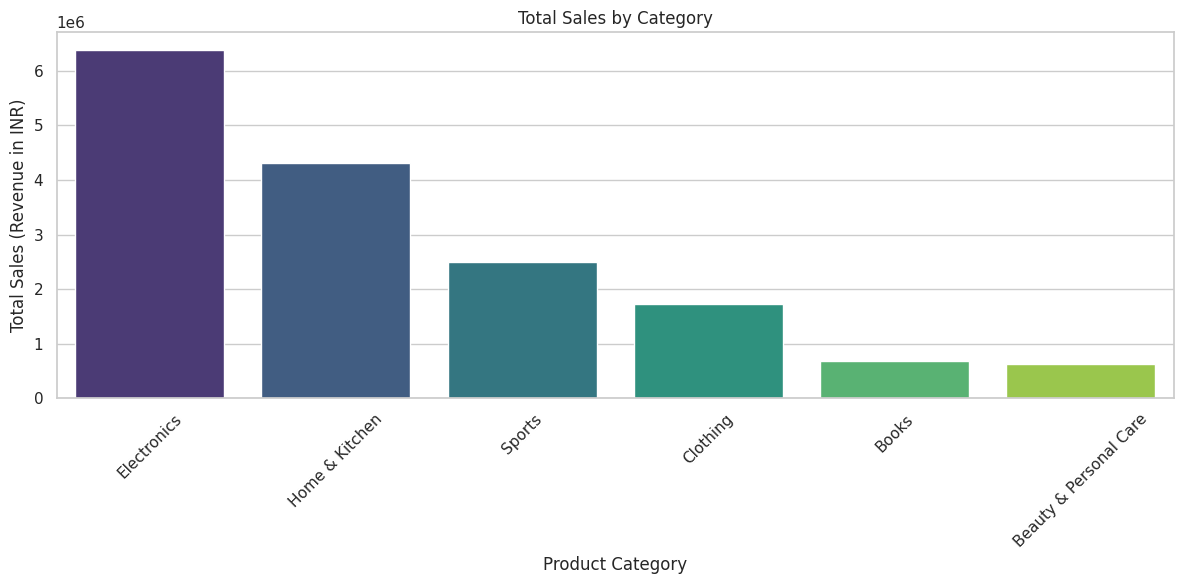

 Step 6: EDA visualizations generated successfully.


In [16]:
#@title Step 6: Exploratory Data Analysis (EDA)
# ---
# Visually explore the data to uncover patterns and insights.
# ---
print("\n⏳ Step 6: Generating visualizations for EDA...")
sns.set(style="whitegrid")

# --- Plot 1: Monthly Revenue Trend ---
print("\n--- Plot 1: Monthly Revenue Trend ---")
plt.figure(figsize=(12, 6))
monthly_revenue = df.set_index('Date').resample('M')['TotalAmount'].sum()
monthly_revenue.plot(kind='line', marker='o', color='steelblue', title='Monthly Revenue Trend')
plt.xlabel("Month")
plt.ylabel("Revenue (INR)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Plot 2: Total Sales by Category ---
print("\n--- Plot 2: Total Sales by Category ---")
plt.figure(figsize=(12, 6))
top_categories = df.groupby('Category')['TotalAmount'].sum().sort_values(ascending=False)
sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')
plt.title('Total Sales by Category')
plt.xlabel("Product Category")
plt.ylabel("Total Sales (Revenue in INR)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(" Step 6: EDA visualizations generated successfully.")



In [ ]:
#@title Step 7: Hypothesis Testing (Python & R)
# ---
# Hypothesis:
# H₀ (Null): Weekend sales = Weekday sales
# H₁ (Alt): Weekend sales ≠ Weekday sales
# ---
print("\n Step 7: Performing Hypothesis Testing...")

from scipy.stats import ttest_ind

# Split data into weekend and weekday sales
weekend_sales = df_cleaned[df_cleaned['Is_Weekend'] == 1]['TotalAmount']
weekday_sales = df_cleaned[df_cleaned['Is_Weekend'] == 0]['TotalAmount']

# Python T-Test
t_stat, p_value = ttest_ind(weekend_sales, weekday_sales, equal_var=False)  # Welch’s t-test

print("\n--- Python T-Test Result ---")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("✅ Conclusion: Significant difference exists between Weekend and Weekday sales.")
else:
    print("ℹ Conclusion: No significant difference between Weekend and Weekday sales.")

# R T-Test using rpy2
print("\n--- R T-Test Result ---")
%R -i df_cleaned
%R t_test_result <- t.test(TotalAmount ~ Is_Weekend, data = df_cleaned, var.equal=FALSE)
%R print(t_test_result)


In [22]:
#@title Step 8: Machine Learning Model Training (Corrected)
# ---
# 1. Forecasting: Sales ko predict karne ke liye (LSTM).
# 2. Clustering: Customers ko segment karne ke liye (KMeans).
# 3. Classification: High-value orders ko predict karne ke liye.
# ---
print("\n Step 8: Training Machine Learning Models...")

# --- 8.A: Forecasting (LSTM) ---
print("--- Training LSTM for Sales Forecasting...")
ts_data = df_cleaned.groupby('Date')['TotalAmount'].sum().resample('D').sum()
scaler = MinMaxScaler(feature_range=(0, 1))
ts_scaled = scaler.fit_transform(ts_data.values.reshape(-1,1))

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60
X, y = create_dataset(ts_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X, y, epochs=15, batch_size=32, verbose=0)

# Forecast for next 90 days
from collections import deque
temp_input = deque(ts_scaled[-time_step:].flatten(), maxlen=time_step)
lst_output=[]
for _ in range(90):
    x_input = np.array(list(temp_input)).reshape((1, time_step, 1))
    yhat = lstm_model.predict(x_input, verbose=0)
    temp_input.append(float(yhat[0][0]))
    lst_output.append(yhat[0][0])

lstm_forecast = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)).flatten()
print("LSTM model trained.")

# --- 8.B: Customer Segmentation (KMeans) ---
print("\n--- Training KMeans for Customer Segmentation...")
snapshot_date = df_cleaned['Date'].max() + timedelta(days=1)
rfm = df_cleaned.groupby('CustomerID').agg({
    'Date': lambda date: (snapshot_date - date.max()).days,
    'OrderID': 'nunique',
    'TotalAmount': 'sum'
}).rename(columns={'Date': 'Recency', 'OrderID': 'Frequency', 'TotalAmount': 'MonetaryValue'})
rfm_scaled = StandardScaler().fit_transform(rfm)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
print(" KMeans clustering completed.")

# --- 8.C: Classification ---
print("\n--- Training Classification model for High-Value Orders...")
threshold = df_cleaned['TotalAmount'].quantile(0.75)
df_cleaned['Is_High_Value'] = (df_cleaned['TotalAmount'] > threshold).astype(int)
features = ['Category', 'Region', 'Quantity', 'UnitPrice', 'Is_Weekend']
target = 'Is_High_Value'
X = df_cleaned[features]
y = df_cleaned[target]

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = np.concatenate([
    encoder.fit_transform(X[['Category', 'Region']]),
    X[['Quantity', 'UnitPrice', 'Is_Weekend']].values
], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
print(" Classification model trained.")

# --- Final Success Message ---
print("\n All ML models trained successfully!")



 Step 8: Training Machine Learning Models...
--- Training LSTM for Sales Forecasting...
LSTM model trained.

--- Training KMeans for Customer Segmentation...
 KMeans clustering completed.

--- Training Classification model for High-Value Orders...
 Classification model trained.

 All ML models trained successfully!


In [24]:
#@title Step 9: Model Evaluation & Saving Artifacts
# ---
# Models ki performance check karte hain aur unhein file mein save karte hain dashboard ke liye.
# ---

from sklearn.metrics import classification_report, silhouette_score
import joblib

print("\n Step 9: Evaluating models and saving artifacts...")

# --- Classification Evaluation ---
if 'clf' in globals() and 'X_test' in globals():
    y_pred = clf.predict(X_test)
    print("\n--- Classification Model Performance ---")
    print(classification_report(y_test, y_pred))
else:
    print(" Classification model not found. Run Step 8 first.")

# --- Clustering Evaluation ---
if 'rfm' in globals() and 'rfm_scaled' in globals():
    score = silhouette_score(rfm_scaled, rfm['Cluster'])
    print(f"\n--- Clustering Model Performance ---")
    print(f"Silhouette Score: {score:.4f} (Closer to 1 is better)")
else:
    print(" Clustering model not found. Run Step 8 first.")

# --- Save Artifacts ---
if 'df_cleaned' in globals():
    df_cleaned.to_csv('cleaned_sales_data.csv', index=False)
if 'rfm' in globals():
    rfm.to_csv('rfm_clusters.csv')
if 'ts_data' in globals() and 'lstm_forecast' in globals():
    forecast_df = pd.DataFrame({
        'Date': pd.date_range(start=ts_data.index[-1] + timedelta(days=1), periods=90),
        'Forecast': lstm_forecast
    })
    forecast_df.to_csv('sales_forecast.csv', index=False)

if 'clf' in globals():
    joblib.dump(clf, 'classification_model.joblib')
if 'encoder' in globals():
    joblib.dump(encoder, 'onehot_encoder.joblib')

print("\n Step 9: All data and models saved for the dashboard.")



⏳ Step 9: Evaluating models and saving artifacts...

--- Classification Model Performance ---
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       375
           1       0.92      0.90      0.91       125

    accuracy                           0.95       500
   macro avg       0.94      0.93      0.94       500
weighted avg       0.95      0.95      0.95       500


--- Clustering Model Performance ---
Silhouette Score: 0.2974 (Closer to 1 is better)

 Step 9: All data and models saved for the dashboard.


In [ ]:
#@title Step 10: Interactive UI Deployment (Streamlit or Gradio)
# ---
# Upar ke saare 9 steps run karne ke baad hi is cell ko run karein.
# Neeche diye gaye variable ko badal kar aap apna pasandida dashboard launch kar sakte hain.
# ---

UI_CHOICE = 'Gradio'  # 'Streamlit' ya 'Gradio' choose karein

print(f"\n Step 10: Launching the '{UI_CHOICE}' dashboard...")

# =========================================================
# --- STREAMLIT DEPLOYMENT ---
# =========================================================
if UI_CHOICE == 'Streamlit':
    with open("app.py", "w") as f:
        f.write('''
import streamlit as st
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

st.set_page_config(page_title="SalesSense AI Dashboard", layout="wide")

@st.cache_data
def load_data():
    df = pd.read_csv("cleaned_sales_data.csv", parse_dates=["Date"])
    rfm_df = pd.read_csv("rfm_clusters.csv")
    forecast_df = pd.read_csv("sales_forecast.csv", parse_dates=["Date"])
    return df, rfm_df, forecast_df

df, rfm_df, forecast_df = load_data()

st.title("🚀 SalesSense AI Dashboard")
st.sidebar.title("Navigation")
page = st.sidebar.radio("Go to", [" Overview & Forecast", " Deep-Dive Analytics", "👥 Customer Segments"])

if page == " Overview & Forecast":
    st.header("Sales Forecast for the Next 3 Months")
    historical_data = df.groupby("Date")["TotalAmount"].sum().reset_index()
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=historical_data["Date"], y=historical_data["TotalAmount"], mode="lines", name="Historical Sales"))
    fig.add_trace(go.Scatter(x=forecast_df["Date"], y=forecast_df["Forecast"], mode="lines", name="Forecasted Sales", line=dict(dash="dash", color="red")))
    st.plotly_chart(fig, use_container_width=True)

elif page == "Deep-Dive Analytics":
    st.header("Deep-Dive Analytics")
    col1, col2 = st.columns(2)
    top_categories = df.groupby("Category")["TotalAmount"].sum().nlargest(5).reset_index()
    fig_cat = px.bar(top_categories, x="Category", y="TotalAmount", title="Top 5 Categories", color="Category")
    col1.plotly_chart(fig_cat, use_container_width=True)

    region_sales = df.groupby("Region")["TotalAmount"].sum().reset_index()
    fig_region = px.pie(region_sales, names="Region", values="TotalAmount", title="Sales by Region", hole=0.3)
    col2.plotly_chart(fig_region, use_container_width=True)

elif page == "👥 Customer Segments":
    st.header("Customer Segmentation (RFM)")
    fig_3d = px.scatter_3d(rfm_df, x="Recency", y="Frequency", z="MonetaryValue", color="Cluster", hover_data=["CustomerID"])
    st.plotly_chart(fig_3d, use_container_width=True)
        ''')
    print(" Streamlit app saved as app.py → Run it with: streamlit run app.py")

# =========================================================
# --- GRADIO DEPLOYMENT ---
# =========================================================
elif UI_CHOICE == 'Gradio':
    import gradio as gr
    import plotly.express as px
    import plotly.graph_objects as go
    import pandas as pd
    import numpy as np
    import joblib

    # Load files
    df = pd.read_csv("cleaned_sales_data.csv", parse_dates=["Date"])
    rfm_df = pd.read_csv("rfm_clusters.csv")
    forecast_df = pd.read_csv("sales_forecast.csv", parse_dates=["Date"])
    clf_model = joblib.load("classification_model.joblib")
    encoder = joblib.load("onehot_encoder.joblib")

    # Helper functions
    def plot_forecast():
        historical_data = df.groupby("Date")["TotalAmount"].sum().reset_index()
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=historical_data["Date"], y=historical_data["TotalAmount"], mode="lines", name="Historical Sales"))
        fig.add_trace(go.Scatter(x=forecast_df["Date"], y=forecast_df["Forecast"], mode="lines", name="Forecasted Sales", line=dict(dash="dash", color="red")))
        fig.update_layout(title="Historical vs. Forecasted Sales")
        return fig

    def plot_top_categories():
        top_categories = df.groupby("Category")["TotalAmount"].sum().nlargest(5).reset_index()
        return px.bar(top_categories, x="Category", y="TotalAmount", title="Top 5 Categories by Revenue", color="Category")

    def plot_region_sales():
        region_sales = df.groupby("Region")["TotalAmount"].sum().reset_index()
        return px.pie(region_sales, names="Region", values="TotalAmount", title="Sales Distribution by Region", hole=0.3)

    def plot_customer_segments():
        return px.scatter_3d(rfm_df, x="Recency", y="Frequency", z="MonetaryValue", color="Cluster", hover_data=["CustomerID"], title="3D View of Customer Segments")

    def predict_high_value(category, region, quantity, unit_price, is_weekend):
        input_data = pd.DataFrame({
            "Category": [category],
            "Region": [region],
            "Quantity": [quantity],
            "UnitPrice": [unit_price],
            "Is_Weekend": [1 if is_weekend == "Weekend" else 0]
        })
        encoded_cats = encoder.transform(input_data[["Category", "Region"]])
        final_features = np.concatenate([encoded_cats, input_data[["Quantity", "UnitPrice", "Is_Weekend"]].values], axis=1)
        probability = clf_model.predict_proba(final_features)[0]
        return {"High-Value Order": float(probability[1]), "Normal Order": float(probability[0])}

    with gr.Blocks(theme=gr.themes.Soft(), title="SalesSense AI") as demo:
        gr.Markdown("#  SalesSense AI Dashboard (Gradio Version)")

        with gr.Tab(" Overview & Forecast"):
            gr.Markdown("### Sales Forecast for the Next 3 Months")
            gr.Plot(plot_forecast)

        with gr.Tab(" Deep-Dive Analytics"):
            gr.Row([gr.Plot(plot_top_categories), gr.Plot(plot_region_sales)])

        with gr.Tab(" Customer Segments"):
            gr.Plot(plot_customer_segments)
            gr.DataFrame(value=rfm_df.groupby("Cluster").agg(
                Recency=("Recency","mean"),
                Frequency=("Frequency","mean"),
                MonetaryValue=("MonetaryValue","mean")).round(2),
                label="Cluster Summary")

        with gr.Tab(" High-Value Order Predictor"):
            category = gr.Dropdown(df["Category"].unique().tolist(), label="📦 Product Category")
            region = gr.Dropdown(df["Region"].unique().tolist(), label="📍 Region")
            qty = gr.Slider(1, 20, value=2, step=1, label=" Quantity")
            price = gr.Number(label=" Unit Price (₹)")
            day = gr.Radio(["Weekday", "Weekend"], label=" Day of Purchase")
            output = gr.Label(num_top_classes=2, label="Prediction Result")

            gr.Button("Predict").click(
                predict_high_value,
                inputs=[category, region, qty, price, day],
                outputs=output
            )

    demo.launch(share=True, debug=True)

else:
    print(f" Invalid UI_CHOICE: '{UI_CHOICE}'. Please choose either 'Streamlit' or 'Gradio'.")



 Step 10: Launching the 'Gradio' dashboard...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6e32f6ac901e989220.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
